<a href="https://colab.research.google.com/github/merazAfridi/Blood-Cell-Segmentation/blob/main/1_Blood_cell_segmentation_final_(U_NET)%2C_(128).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras


In [ ]:
data_path = r'C:\Users\User\Final data'

In [ ]:
image_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
mask_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'

(1328, 128, 128, 3)
uint8


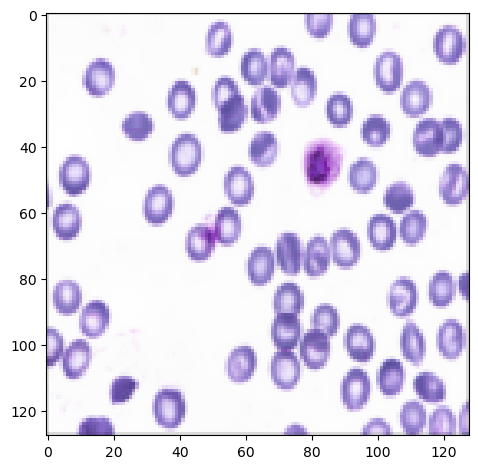

In [ ]:
row = 128
columns = 128

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
training_images = os.listdir(train_data_path)
training_images.sort()


X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_images:
    path = os.path.join(image_data_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    X[index] = image
    index += 1

print(X.shape)

print(X.dtype)
imshow(X[0])

(1328, 128, 128, 3)
uint8


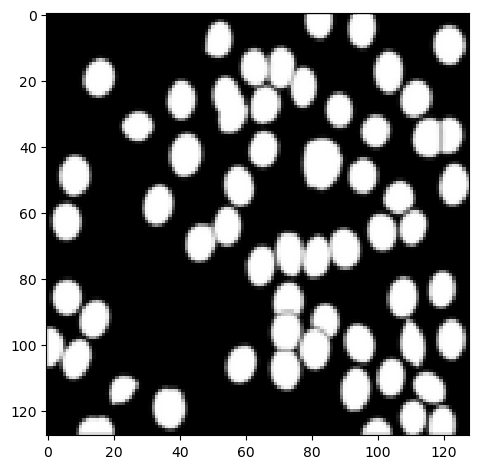

In [ ]:
train_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'
training_masks = os.listdir(train_data_path)
training_masks.sort()

y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_masks:
    path = os.path.join(mask_data_path, x)
#     print(path)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y[index] = image
    index += 1

print(y.shape)
type(y)
print(y.dtype)
imshow(y[0])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)



(1062, 128, 128, 3)
(1062, 128, 128, 3)

(266, 128, 128, 3)
(266, 128, 128, 3)


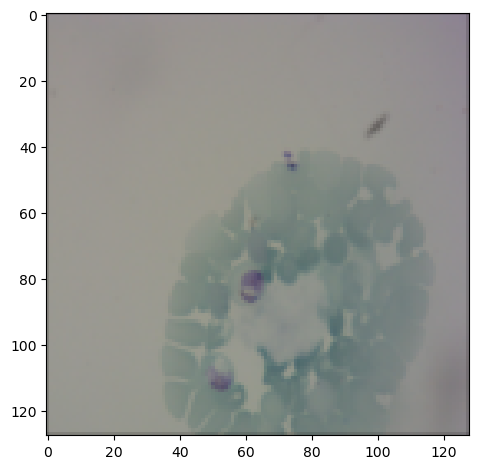

In [ ]:
imshow(X_train[0])

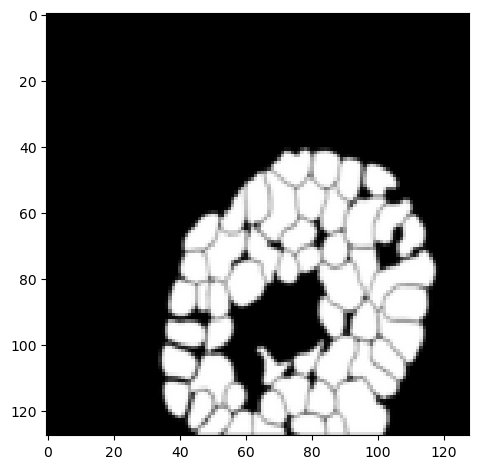

In [ ]:
imshow(y_train[0])

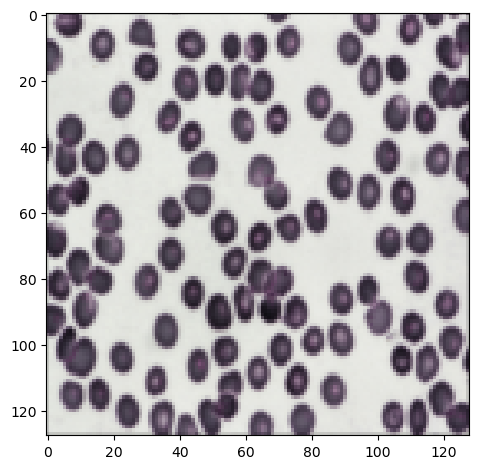

In [ ]:
imshow(X_test[0])

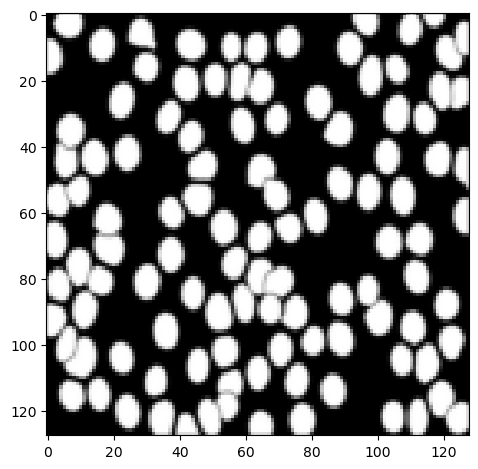

In [ ]:
imshow(y_test[0])

In [ ]:
y_train = y_train.astype('bool')
print(y_train.dtype)

bool


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
def dice_coef(a, b):
    hi = a
    pred = b
    hi = keras.layers.Flatten()(hi)   #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index(a, b):
    hi = a
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [ ]:
from keras import backend as K
from keras.layers import concatenate, Conv2DTranspose, Activation
from keras.layers import BatchNormalization


from keras.layers import Conv2D, Input, AvgPool2D
from keras.models import Model

dropout_rate = 0.5

#input_shape = (128, 128, 3)
#n_labels    = 3

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision==True:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.054,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

    opt = keras.optimizers.Adam(learning_rate=3e-4)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=[dice_coef, jaccard_index])
    #dice_coef, jaccard_index

    return model

In [ ]:
input_shape = (128,128,3)
n_labels = 3
model = model_build_func(input_shape, n_labels)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 128, 128, 32)         896       ['input_image[0][0]']         
                                                                                                  
 batch_normalization_30 (Ba  (None, 128, 128, 32)         512       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_30 (Activation)  (None, 128, 128, 32)         0         ['batch_normalization_30

In [ ]:
print(X_train.dtype)
print(y_train.dtype)

print(type(X_train))
print(type(y_train))

X_train = X_train.astype('uint8')
y_train = y_train.astype('float64')

print(X_train.dtype)
print(y_train.dtype)

uint8
float64
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
uint8
float64


In [ ]:
print(X_train.shape)
print(y_train.shape)


(1062, 128, 128, 3)
(1062, 128, 128, 3)


In [ ]:
filepath = r"C:\Users\User/cp.ckpt"
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#mode='min'
callbacks_list = [earlystopper, checkpoint]
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=5, callbacks=callbacks_list)

Epoch 1/5
120/120 [==============================] - ETA: 0s - loss: 0.1389 - dice_coef: 0.8896 - jaccard_index: 0.8016
Epoch 1: val_loss improved from inf to 0.13302, saving model to C:\Users\User\cp.ckpt
INFO:tensorflow:Assets written to: C:\Users\User\cp.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\User\cp.ckpt\assets


120/120 [==============================] - 419s 3s/step - loss: 0.1389 - dice_coef: 0.8896 - jaccard_index: 0.8016 - val_loss: 0.1330 - val_dice_coef: 0.8926 - val_jaccard_index: 0.8064
Epoch 2/5
120/120 [==============================] - ETA: 0s - loss: 0.1250 - dice_coef: 0.9045 - jaccard_index: 0.8261
Epoch 2: val_loss improved from 0.13302 to 0.11227, saving model to C:\Users\User\cp.ckpt
INFO:tensorflow:Assets written to: C:\Users\User\cp.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\User\cp.ckpt\assets


120/120 [==============================] - 420s 4s/step - loss: 0.1250 - dice_coef: 0.9045 - jaccard_index: 0.8261 - val_loss: 0.1123 - val_dice_coef: 0.9120 - val_jaccard_index: 0.8389
Epoch 3/5
120/120 [==============================] - ETA: 0s - loss: 0.1120 - dice_coef: 0.9159 - jaccard_index: 0.8453
Epoch 3: val_loss did not improve from 0.11227
120/120 [==============================] - 426s 4s/step - loss: 0.1120 - dice_coef: 0.9159 - jaccard_index: 0.8453 - val_loss: 0.1222 - val_dice_coef: 0.9086 - val_jaccard_index: 0.8331
Epoch 4/5
120/120 [==============================] - ETA: 0s - loss: 0.1001 - dice_coef: 0.9258 - jaccard_index: 0.8622
Epoch 4: val_loss did not improve from 0.11227
120/120 [==============================] - 416s 3s/step - loss: 0.1001 - dice_coef: 0.9258 - jaccard_index: 0.8622 - val_loss: 0.1765 - val_dice_coef: 0.8701 - val_jaccard_index: 0.7716
Epoch 5/5
120/120 [==============================] - ETA: 0s - loss: 0.0935 - dice_coef: 0.9319 - jaccard_in

INFO:tensorflow:Assets written to: C:\Users\User\cp.ckpt\assets


120/120 [==============================] - 428s 4s/step - loss: 0.0935 - dice_coef: 0.9319 - jaccard_index: 0.8728 - val_loss: 0.0918 - val_dice_coef: 0.9197 - val_jaccard_index: 0.8516


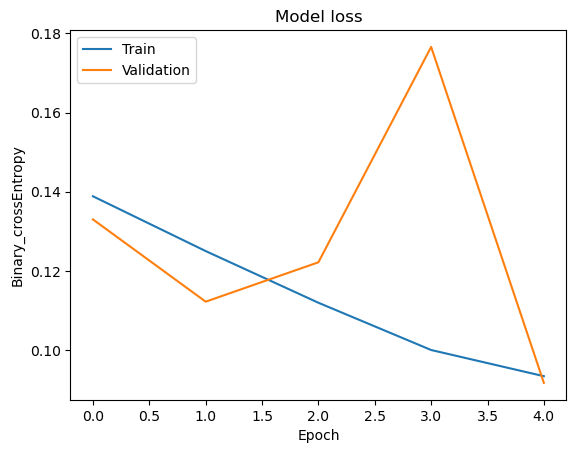

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

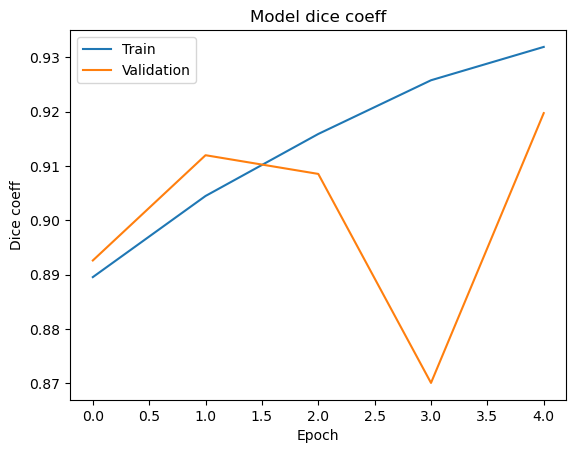

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

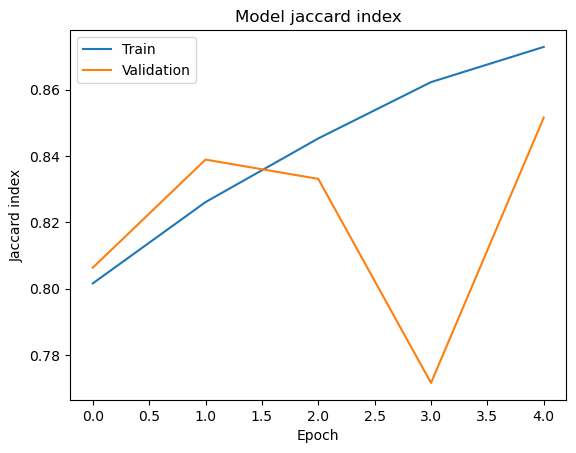

In [ ]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
X_test = X_test.astype('uint8')
y_test = y_test.astype('float64')


In [ ]:
model.load_weights(r"C:\Users\User/cp.ckpt")
test_preds = model.predict(X_test)
print(test_preds.shape)
print(type(test_preds))

9/9 [==============================] - 17s 2s/step
(266, 128, 128, 3)
<class 'numpy.ndarray'>


In [ ]:
def dice_coef2(a, b):

    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi) # K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

float64
float32
Dice Co-efficient:  tf.Tensor(0.7709572, shape=(), dtype=float32)
Jaccard-index:  tf.Tensor(0.62728256, shape=(), dtype=float32)


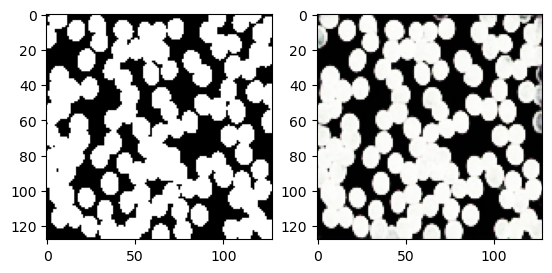

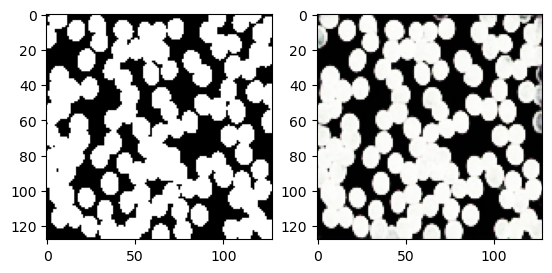

In [ ]:
from skimage.io import imshow_collection
print(y_test[0].dtype)
print(test_preds[0].dtype)
i = y_test[0]
j = test_preds[0]
result = dice_coef2(i,j)
print('Dice Co-efficient: ', result)
result2 = jaccard_index2(i,j)
print('Jaccard-index: ', result2)
x = np.zeros((2, row, columns, 3))
x[0] = i
x[1] = j
imshow_collection(x)

In [ ]:
#dice_list = np.array(len(test_preds))
#jaccard_list = np.array(len(test_preds))
avg_dice = 0
avg_jaccard = 0
for x in range(len(test_preds)):
    i = y_test[x]
    j = test_preds[x]
    avg_dice = avg_dice + tf.get_static_value(dice_coef2(i,j))
    avg_jaccard = avg_jaccard + tf.get_static_value(jaccard_index2(i,j))

print('Average Test Dice co-efficent: ', avg_dice/len(test_preds))
print('Average Test Jaccrad Index: ', avg_jaccard/len(test_preds))

Average Test Dice co-efficent:  0.7665539471278513
Average Test Jaccrad Index:  0.623119552220617


In [ ]:
print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))

Lowest training loss:  0.0934704914689064
Lowest validation loss:  0.09177185595035553
Highest training dice coefficient:  0.931914210319519
Highest validation dice coefficient:  0.9197394251823425
Highest training jaccrad index:  0.8728493452072144
Highest validation jaccard index:  0.8515533208847046
